In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

car = imread('http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/dd58e02d-51a5-4bfd-87af-ff51c576086e___2014-mahindra-scorpio-suv-10.jpg.jpeg')

plt.imshow(car)
plt.show()

<Figure size 640x480 with 1 Axes>

In [ ]:
# convert the image to greyscale
gray_car = rgb2gray(car)

# gaussian pyramid


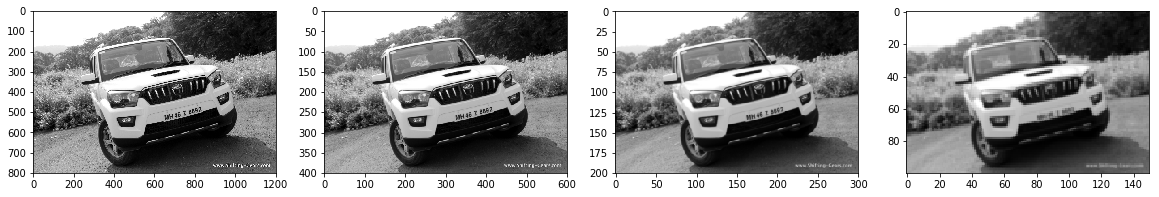

In [34]:
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from scipy.ndimage.filters import convolve
from skimage.filters import sobel
from skimage.transform import rescale

guassian_kernel = np.array([[0.0113, 0.0838, 0.0113],[0.0838,0.6193,0.0838],[0.0113, 0.0838, 0.0113]])

# convert the image to greyscale
gray_car = rgb2gray(car)

# Create a Gaussian pyramid by convolving the input image with a Gaussian kernel
# and successively down-sample each direction by half
resized_L0 = np.copy(gray_car)
resized_L1 = rescale(convolve(resized_L0, guassian_kernel), 0.5)
resized_L2 = rescale(convolve(resized_L1, guassian_kernel), 0.5)
resized_L3 = rescale(convolve(resized_L2, guassian_kernel), 0.5)


fig, ax = plt.subplots(ncols=4, figsize=(20,10))
ax[0].imshow(resized_L0, cmap="gray")
ax[1].imshow(resized_L1, cmap="gray")
ax[2].imshow(resized_L2, cmap="gray")
ax[3].imshow(resized_L3, cmap="gray")
plt.show()

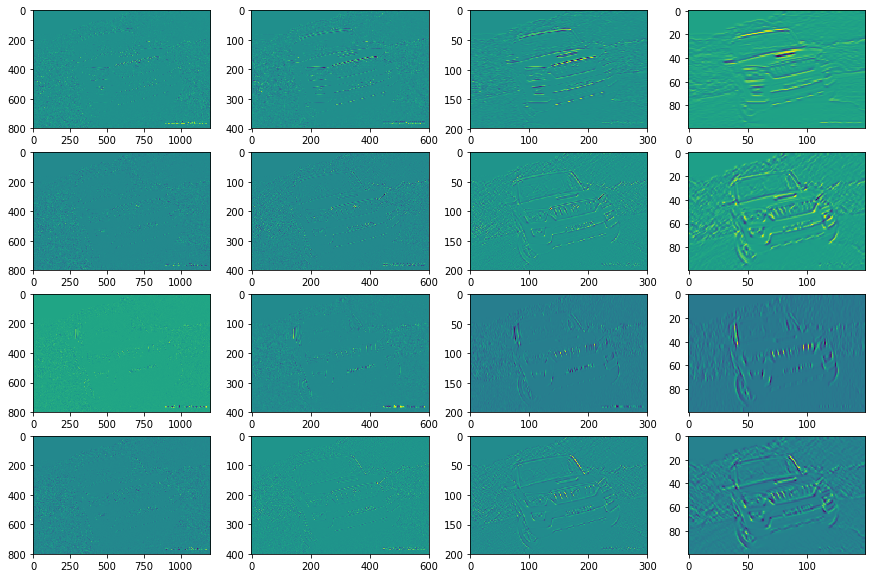

In [42]:
from scipy.ndimage.filters import convolve
from skimage.filters import sobel

# directional kernels at 0, 45, 90 and 135 degrees
k0 = np.array([[-1, -1, -1],[2,2,2],[-1, -1, -1]])
k45 = np.array([[-1, -1, 2],[-1, 2, -1],[2, -1, -1]])
k90 = np.array([[-1, 2, -1],[-1, 2, -1],[-1, 2, -1]])
k135 = np.array([[2, -1, -1],[-1, 2, -1],[-1, -1, 2]])

# These images are next convolved with
# directional filters at different orientation kernels for edge detection in the horizontal (0°),
# vertical (90°) and diagonal (45°, 135°) directions

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,10))
ax[0][0].imshow(convolve(resized_L0, k0))
ax[0][1].imshow(convolve(resized_L1, k0))
ax[0][2].imshow(convolve(resized_L2, k0))
ax[0][3].imshow(convolve(resized_L3, k0))

ax[1][0].imshow(convolve(resized_L0, k45))
ax[1][1].imshow(convolve(resized_L1, k45))
ax[1][2].imshow(convolve(resized_L2, k45))
ax[1][3].imshow(convolve(resized_L3, k45))

ax[2][0].imshow(convolve(resized_L0, k90))
ax[2][1].imshow(convolve(resized_L1, k90))
ax[2][2].imshow(convolve(resized_L2, k90))
ax[2][3].imshow(convolve(resized_L3, k90))

ax[3][0].imshow(convolve(resized_L0, k135))
ax[3][1].imshow(convolve(resized_L1, k135))
ax[3][2].imshow(convolve(resized_L2, k135))
ax[3][3].imshow(convolve(resized_L3, k135))

plt.show()

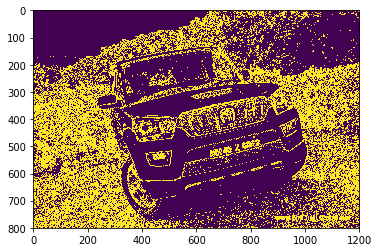

In [48]:
from skimage.filters import threshold_otsu
 
def get_binary(image):
    thresh = threshold_otsu(image)
    binary = image > thresh
    return binary

plt.imshow(get_binary(convolve(resized_L0, k0)) | get_binary(convolve(resized_L0, k45)) | get_binary(convolve(resized_L0, k90)) | get_binary(convolve(resized_L0, k135)))